In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.ndimage import rotate, shift,zoom
import random
import os 
import glob
import ast

import matplotlib.pyplot as plt
import pydicom

from tqdm import tqdm



SEED = 42

# Python
random.seed(SEED)
# Numpy
np.random.seed(SEED)
# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # si plusieurs GPU

# **Importation du dictionnaire**

In [2]:
# charger
loaded = np.load("/kaggle/input/cta-dataset-22-09/CTA_dataset_22_09.npz", allow_pickle=True)
data = {key: loaded[key].item() for key in loaded.files}
# loaded est un dict-like, data est un dictionnaire

In [3]:
len(data['patient_0']['cubes'])

6

# **On split le dictionnaire entre train/val/test**

In [4]:
from sklearn.model_selection import train_test_split

# toutes les clés patients
all_patients = list(data.keys())


# split train vs temp (train + val/test)
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.3, random_state=42
)

# split val vs test
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

print(f"{len(train_patients)} train, {len(val_patients)} val, {len(test_patients)} test")

train_data = {k: data[k] for k in train_patients}
val_data = {k: data[k] for k in val_patients}
test_data = {k: data[k] for k in test_patients}

845 train, 181 val, 182 test


# **Création d'un dataset PyTorch**

In [5]:
class CubesDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.transform = transform
        self.cubes = np.concatenate([d['cubes'] for d in data_dict.values()], axis=0)
        self.positions = np.concatenate([d['positions'] for d in data_dict.values()], axis=0)
        self.labels = np.concatenate([d['labels'] for d in data_dict.values()], axis=0)

    def __len__(self):
        return len(self.cubes)


    def __getitem__(self, idx):
        cube = self.cubes[idx]
        label = self.labels[idx]
        position = self.positions[idx]

        # augmentation seulement si transform est défini
        if self.transform:
            cube = self.transform(tio.ScalarImage(tensor=cube[np.newaxis]))
            cube = cube.data.squeeze(0).numpy()

        # convertir en tenseur PyTorch
        cube = torch.tensor(cube, dtype=torch.float32).unsqueeze(0)

        # concaténer position (13) et label (1) → shape (14,)
        y = np.concatenate([position, label], axis=0)
        y = torch.tensor(y, dtype=torch.float32)

        return cube, y

# **Ajout d'un paramètre de transformations**

In [6]:
!pip install torchio

In [7]:
import torchio as tio

# Compose plusieurs transformations aléatoires
transform = tio.Compose([
    # Flip aléatoire sur n’importe quel axe
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),

    # Rotation et scaling aléatoire
    tio.RandomAffine(
        scales=(0.9, 1.1),  # facteur de zoom aléatoire
        degrees=15,          # rotation en degrés
        translation=5        # translation en voxels
    ),

    # Ajouter un bruit gaussien aléatoire
    tio.RandomNoise(mean=0, std=0.01),

    # Elastic deformation aléatoire (déformation douce)
    tio.RandomElasticDeformation(
        num_control_points=7,
        max_displacement=3.0,
        locked_borders=2
    )
])

# **Création des DataLoaders**

In [8]:
# Datasets
train_dataset = CubesDataset(train_data,transform=transform)
val_dataset = CubesDataset(val_data,transform=None)
test_dataset = CubesDataset(test_data,transform=None)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

for cube, y in train_loader:
    print(cube.shape)  # (batch_size, 1, 48, 48, 48)
    print(y.shape)     # (batch_size, 14)
    break

torch.Size([8, 1, 48, 48, 48])
torch.Size([8, 14])


# **Création du modèle**

In [9]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet3DClassifier(nn.Module):
    def __init__(self, in_ch=1, base_ch=16):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock3D(in_ch, base_ch)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock3D(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = ConvBlock3D(base_ch*2, base_ch*4)

        # Decoder
        self.up2 = nn.ConvTranspose3d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock3D(base_ch*4, base_ch*2)

        self.up1 = nn.ConvTranspose3d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock3D(base_ch*2, base_ch)

        # Classifier pour 14 sorties (13 positions + 1 label)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d((1,1,1)),
            nn.Flatten(),
            nn.Linear(base_ch, 14)

        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.classifier(d1)  # (B,14)
        return out

# **Loss combinée BCE**

In [10]:
import torch.nn.functional as F

def combined_loss(pred, target, alpha=0.1):
    pos_pred = torch.sigmoid(pred[:, :13])   # si sortie logit
    pos_target = target[:, :13]
    label_pred = pred[:, 13:]
    label_target = target[:, 13:]

    loss_pos = F.binary_cross_entropy(pos_pred, pos_target)
    loss_label = F.binary_cross_entropy_with_logits(label_pred, label_target)

    return alpha * loss_pos + loss_label

# **Fonction d'entrainement**

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device="cuda"):


    model.to(device)
    best_val_acc =0.7

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}")

        if val_loader is not None:
            val_loss, val_acc, val_positions_loss = evaluate_model(model, val_loader, criterion, device)
            print(f"         Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Positions BCE: {val_positions_loss:.4f}")

             # ----------- Sauvegarde si meilleure val_acc -----------
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_path = "modele_CTA_22_09.pth"
                torch.save(model.state_dict(), save_path)
                print(f"         -> Nouveau meilleur modèle sauvegardé ! (Val Acc: {best_val_acc:.4f})")

    return model

# **Fonction d'évaluation**

In [12]:
import torch.nn.functional as F


def evaluate_model(model, loader, criterion, device="cuda"):
    """
    Évalue le modèle sur un loader donné.
    Loss combinée = BCE(label) + alpha * BCE(positions)
    Retourne :
      - avg_loss : loss totale combinée
      - accuracy_label : précision sur le label binaire
      - avg_positions_loss : BCE moyenne sur les positions (0 à 12)
    """
    model.eval()
    running_loss = 0.0
    correct_label = 0
    positions_loss_total = 0.0  # pour BCE positions

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)  # (B,14)


            # Calcul de la loss combinée via la fonction criterion
            loss = criterion(outputs, labels,alpha=0.1)
            running_loss += loss.item() * inputs.size(0)

            # Accuracy binaire pour le label (colonne 13)
            probs_label = torch.sigmoid(outputs[:, -1])
            best_thresh = 0.65
            preds_label = (probs_label > best_thresh).float()
            labels_binary = labels[:, -1]
            correct_label += (preds_label == labels_binary).sum().item()

            # BCE positions (colonnes 0 à 12)
            pos_pred = torch.sigmoid(outputs[:, :13])
            pos_target = labels[:, :13]
            bce_positions = F.binary_cross_entropy(pos_pred, pos_target, reduction='sum')
            positions_loss_total += bce_positions.item()

    n_samples = len(loader.dataset)
    avg_loss = running_loss / n_samples
    accuracy_label = correct_label / n_samples
    avg_positions_loss = positions_loss_total / n_samples

    return avg_loss, accuracy_label, avg_positions_loss

# **Instanciation du modèle**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DClassifier(in_ch=1, base_ch=32).to(device)
criterion = combined_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### **Si on load un modèle existant**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/kaggle/input/modele_cta_22_09/pytorch/default/1/modele_CTA_22_09.pth", map_location=device))

model = model.to(device)   # envoyer le modèle sur GPU
model.eval()

UNet3DClassifier(
  (enc1): ConvBlock3D(
    (block): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock3D(
    (block): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): InstanceNo

# **Lancement de l'apprentissage**

In [16]:
trained_model = train_model(trained_model, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)

Epoch 1/5 [Train]: 100%|██████████| 634/634 [11:40<00:00,  1.11s/it]


Epoch 1/5, Train Loss: 0.3881
         Val Loss: 0.4257, Val Acc: 0.7974, Val Positions BCE: 2.4813
         -> Nouveau meilleur modèle sauvegardé ! (Val Acc: 0.7974)


Epoch 2/5 [Train]: 100%|██████████| 634/634 [11:41<00:00,  1.11s/it]


Epoch 2/5, Train Loss: 0.3820
         Val Loss: 0.4271, Val Acc: 0.8186, Val Positions BCE: 2.4798
         -> Nouveau meilleur modèle sauvegardé ! (Val Acc: 0.8186)


Epoch 3/5 [Train]: 100%|██████████| 634/634 [11:42<00:00,  1.11s/it]


Epoch 3/5, Train Loss: 0.3789
         Val Loss: 0.4790, Val Acc: 0.8085, Val Positions BCE: 2.5087


Epoch 4/5 [Train]: 100%|██████████| 634/634 [11:44<00:00,  1.11s/it]


Epoch 4/5, Train Loss: 0.3757
         Val Loss: 0.5336, Val Acc: 0.6924, Val Positions BCE: 2.5727


Epoch 5/5 [Train]: 100%|██████████| 634/634 [11:49<00:00,  1.12s/it]


Epoch 5/5, Train Loss: 0.3730
         Val Loss: 0.4717, Val Acc: 0.7873, Val Positions BCE: 2.5218


In [ ]:
# Exemple de valeurs (remplace par tes valeurs réelles)
train_loss = []
val_loss   = []
val_acc    = []

epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(10,5))

# Courbe Loss
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Courbe Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs, val_acc, label='Val Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.save(trained_model.state_dict(), "modele_MRA_18_09.pth")

In [21]:
test_loss, test_acc_label, test_positions = evaluate_model(trained_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc_label:.4f}")

Test Loss: 0.6869, Test Accuracy: 0.6543


In [17]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_best_threshold(model, loader, device="cuda", thresholds=np.arange(0.1, 0.91, 0.05)):
    model.eval()
    all_probs = []
    all_labels = []

    # Récupérer toutes les probabilités et labels
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs[:, -1])  # dernière colonne = label binaire
            all_probs.append(probs.cpu())
            all_labels.append(labels[:, -1].cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    best_acc = 0
    best_thresh = 0
    acc_list = []

    # Tester tous les seuils
    for t in tqdm(thresholds, desc="Testing thresholds"):
        preds = (all_probs > t).float()
        acc = (preds == all_labels).float().mean().item()
        acc_list.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t

    # Afficher la courbe Accuracy vs Threshold
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, acc_list, marker='o')
    plt.xlabel("Seuil")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Threshold pour le label anévrisme")
    plt.grid(True)
    plt.show()

    print(f"Meilleur seuil : {best_thresh:.2f}, Accuracy : {best_acc:.4f}")
    return best_thresh, best_acc

Testing thresholds: 100%|██████████| 17/17 [00:00<00:00, 16828.69it/s]


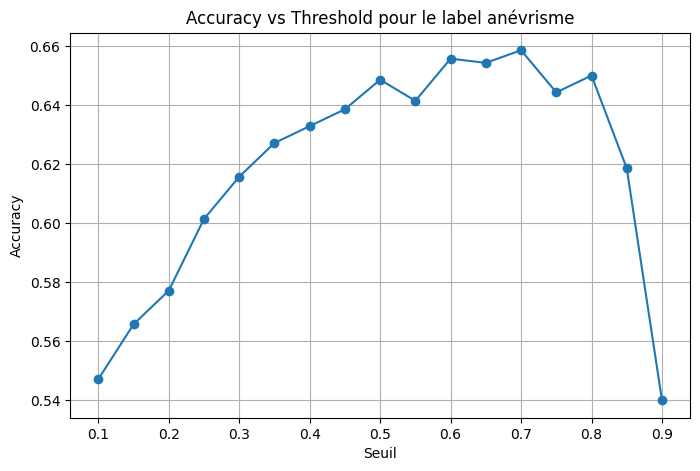

Meilleur seuil : 0.70, Accuracy : 0.6586


In [22]:
best_thresh, best_acc = find_best_threshold(
    model=trained_model,
    loader=test_loader,
    device=device,  # généralement 'cuda'
    thresholds=np.arange(0.1, 0.91, 0.05)
)